In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, Concatenate, LeakyReLU, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# convert to one-hot-encoding
from keras.utils.np_utils import to_categorical 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

np.random.seed(2)

# Error Level Analysis (ELA)

In [ ]:
# initial preparation for ELA (error level analysis) module
from PIL import Image, ImageChops, ImageEnhance
from pylab import *
import os
import itertools
import re

# functions of path images
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

# functions of ELA
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

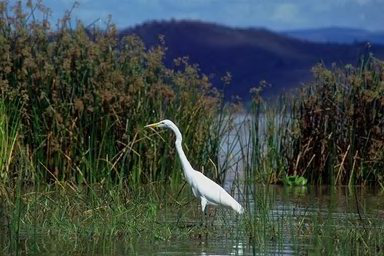

In [ ]:
# sample of Real image
real_image_Au = '/content/drive/MyDrive/casia/Au/Au_ani_00002.jpg'
Image.open(real_image_Au)

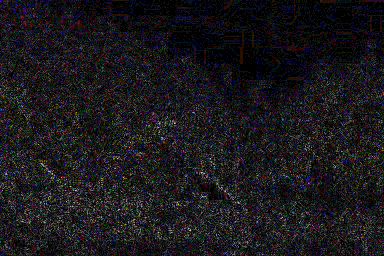

In [ ]:
# After processed with ELA
convert_to_ela_image(real_image_Au, 90)

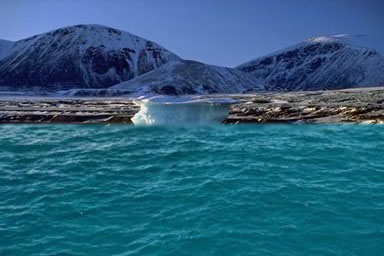

In [ ]:
# Edited image or fake image
fake_image_Tp = '/content/drive/MyDrive/casia/Tp/Tp_D_CNN_M_B_nat00056_nat00099_11105.jpg'
Image.open(fake_image_Tp)

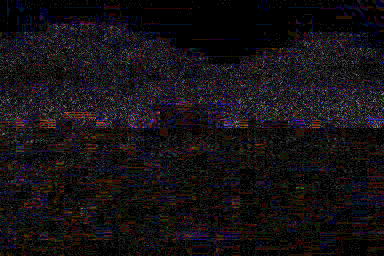

In [ ]:
# compare the result of two ELA which are Fake and real
# based on our observation, we able to detect the ELA result of the REAL and FAKE images
# the background of the image clearly unvisible and some of object in the images slightly visible, but the zebra visible
convert_to_ela_image(fake_image_Tp, 90)

# Preparation of Datasets 

In [ ]:
# Dataset preparation
image_size = (128, 128)

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

X = [] # ELA converted images
Y = [] # 0 = fake; 1 = real

In [ ]:
# this function will extracts some random images from the Au (7492 cut down till 1000 ) and Tp (5124 cut down till 1000)
# to balance out the dataset to avoid more images in one class folder for causing model bias
# ideally 1000 images per class at minimum
import random

path = '/content/drive/MyDrive/casia/Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:1000]
Y = Y[:1000]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
1000 1000


In [ ]:
path = '/content/drive/MyDrive/casia/Tp'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
3064 3064


In [ ]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [ ]:
# train test split with 80:20 ratio
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

2451 2451
613 613


# CNN Model

In [ ]:
# CNN model : VGG16 architecture
# characterized by its simplicity, using only 3×3 convolutional layers stacked on top of each other in increasing depth. 
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

model = build_model()
model.summary()

# initialize initial learning rate, number of epochs to train for and batch size on Adam optimizer
# initialize the model and optimizer (that want to use and binary_crossentropy for 2-class classification
init_lr = 0.001
epochs = 30
bs = 32

optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_acc', 
                               min_delta = 0, 
                               patience = 2, 
                               verbose = 0, 
                               mode = 'auto')

# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

# train the network
H = model.fit(x=aug.flow(X_train, Y_train, batch_size=bs),
	validation_data=(X_val, Y_val), steps_per_epoch=len(X_train) // bs,
	epochs=epochs, callbacks = [early_stopping])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 60, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 115200)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               29491456  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [ ]:
model.save('model_casia_run1.h5')

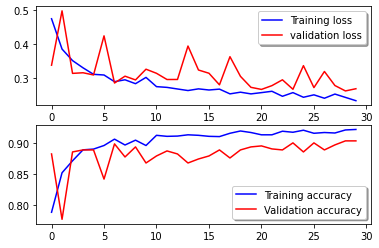

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(H.history['loss'], color='b', label="Training loss")
ax[0].plot(H.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(H.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(H.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

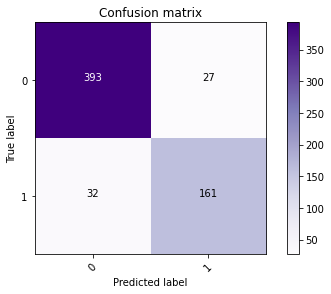

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [ ]:
# Prediction
class_names = ['fake', 'real']

In [ ]:
# The score of the predictions for fake images
fake_image = os.listdir('/content/drive/MyDrive/casia/Tp')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_path = os.path.join('/content/drive/MyDrive/casia/Tp', file_name)
        image = prepare_image(fake_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 2064, Correct: 1988, Acc: 96.31782945736434


In [ ]:
# The score of the predictions for real images
real_image = os.listdir('/content/drive/MyDrive/casia/Au')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join('/content/drive/MyDrive/casia/Au', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


In [ ]:
correct += correct_r
total += total_r
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 7354, Correct: 6192, Acc: 84.19907533315202
Total: 9418, Correct: 8180, Acc: 86.85495858993417
